In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from openai_client import OpenAIClient
from IPython.core.interactiveshell import InteractiveShell

In [2]:
sns.set()
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("expand_frame_repr", False)
pd.set_option('display.float_format', '{:.2f}'.format)
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
products = pd.read_csv("../data/clean_products.csv")
products = products.drop(columns=["raw_data", "id", "raw_length"])

# convert values that say `Not available` to np.nan
products = products.replace("Not available", np.nan)
products.head(3)

,name,size,form,processor,core,frequency,memory,voltage,io,thermal,feature,type,specification,manufacturer,location,description,summary
0,Stratix Device Handbook Volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Altera Corporation,"Innovation Drive, San Jose, CA","The Stratix Device Handbook provides comprehensive information on Altera's Stratix family of devices, including features, architecture, configuration, and technical specifications.","A detailed handbook for Altera's Stratix family of devices, covering features, architecture, and technical specifications."
1,STVW,NaN,NaN,NaN,NaN,NaN,On-chip Frame Memory: 240 x 320 x 18 bits,"VDD: 2.5V - 3.3V, VDDI: 1.65V - 3.3V, VGH: 10V - 20V, VGL: -10V - -5V",NaN,NaN,"Single chip TFT-LCD Controller/Driver, On-chip Frame Memory, Display Resolution: 240 RGB x 320, LCD Driver Output Circuits, Programmable Pixel Color Format, Various Display Data input Format, MCU Interface, RGB Interface, Serial Peripheral Interface, VSYNC Interface, Programmable Partial Display Duty, CABC saving current consumption, Color enhancement, On Chip Build-In Circuits, DCDC Converter, Adjustable VCOM Generation, Non-Volatile (NV) Memory, Timing Controller, Gamma curve, separated RGB Gamma setting, Build-In NV Memory, LCD Initial Register Setting, bits ID setting, VCOM Offset adjustment, Driving Algorithm, Dot Inversion, Column Inversion, Wide Supply Voltage Range, Optimized layout, COG Assembly, Lower Power Consumption",Single Chip TFT-LCD Controller/Driver,"Display Resolution: 240 RGB x 320, Frame Memory Size: 240 x 320 x 18 bits, Source Outputs: 720 RGB Channels, Gate Outputs: 320 Channels, Common Electrode Output, Display Colors: 262K Color Mode, Full Color: 262K RGB max, Idle Mode Off Color: Reduce color RGB, Idle Mode On: Programmable Pixel Color Format, Color Depth: Various Display Data input Format, MCU Interface: Parallel, series MCU Interface, RGB Interface: VSYNC, HSYNC, DOTCLK, ENABLE, DB, Serial Peripheral Interface: SPI Interface, VSYNC Interface, Display Features: Programmable Partial Display Duty, CABC saving current consumption, Color enhancement, On Chip Build-In Circuits: DCDC Converter, Adjustable VCOM Generation, Non-Volatile (NV) Memory: Store Initial Register Setting, Factory Default Value, Module ID, Module Version, etc., Timing Controller: preset Gamma curve, separated RGB Gamma setting, Build-In NV Memory: LCD Initial Register Setting, bits ID setting, VCOM Offset adjustment, Driving Algorithm: Dot Inversion, Column Inversion, Wide Supply Voltage Range: IO Voltage: VDDI, DGND: 1.65V - 3.3V, VDDI: 2.5V - 3.3V, VDD: Analog Voltage: VDD, AGND: 2.5V - 3.3V, On-Chip Power System: Source Voltage: VAP, GVDD, VAN, GVCL: 4.5V - 5.5V, VCOM level: GND, Gate driver HIGH level: VGH, AGND: 10V - 20V, Gate driver LOW level: VGL, AGND: -10V - -5V, Optimized layout: COG Assembly, Operate temperature range: -30°C to 85°C, Lower Power Consumption",Sitronix Technology Corporation,NaN,"The STVW is a single-chip controller/driver for 262K color graphic type TFT-LCD. It consists of source line and gate line driving circuits. This chip is capable of connecting directly to an external microprocessor and accepts 8/9/16/18 bits parallel interface. Display data is stored in the on-chip display data RAM of 240 x 320 x 18 bits. It can perform display data RAM read/write operation without an external operation clock to minimize power consumption. In addition, an integrated power supply circuit necessary to drive liquid crystal is possible to make a display system with the fewest components.","The STVW is a single-chip TFT-LCD controller/driver with on-chip frame memory, supporting various interfaces and programmable display features, designed for low power consumption and high flexibility in display applications."
2,BCM ARM Peripherals,NaN,NaN,ARM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Broadcom Corporation,"Broadcom Europe Ltd, Science Park, Milton Road, Cambridge, CB4 0WW","The BCM ARM Peripherals document provi

In [4]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1479 entries, 0 to 1478
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           1471 non-null   object
 1   size           1083 non-null   object
 2   form           1080 non-null   object
 3   processor      1358 non-null   object
 4   core           698 non-null    object
 5   frequency      1035 non-null   object
 6   memory         1327 non-null   object
 7   voltage        1304 non-null   object
 8   io             1433 non-null   object
 9   thermal        1149 non-null   object
 10  feature        1462 non-null   object
 11  type           1470 non-null   object
 12  specification  1421 non-null   object
 13  manufacturer   1426 non-null   object
 14  location       373 non-null    object
 15  description    1467 non-null   object
 16  summary        1469 non-null   object
dtypes: object(17)
memory usage: 196.6+ KB


In [5]:
# Function to preprocess text
def preprocess_text(text):
    if isinstance(text, str):
        return text.lower()
    return ""

In [6]:
products["name"] = products["name"].apply(preprocess_text)
products["processed_description"] = products["description"].apply(preprocess_text)

In [7]:
# drop products where the name is empty string
products = products[products["name"] != ""]
products.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1471 entries, 0 to 1478
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   name                   1471 non-null   object
 1   size                   1079 non-null   object
 2   form                   1076 non-null   object
 3   processor              1353 non-null   object
 4   core                   697 non-null    object
 5   frequency              1031 non-null   object
 6   memory                 1322 non-null   object
 7   voltage                1300 non-null   object
 8   io                     1426 non-null   object
 9   thermal                1145 non-null   object
 10  feature                1457 non-null   object
 11  type                   1465 non-null   object
 12  specification          1416 non-null   object
 13  manufacturer           1422 non-null   object
 14  location               373 non-null    object
 15  description            146

## Duplicate names

In [9]:
duplicate_products = products[products.duplicated(subset=["name"], keep=False)]
duplicate_products = duplicate_products.sort_values(by="name")

for name, group in duplicate_products.groupby("name"):
    print(f"Name: {name}")
    for index, row in group.iterrows():
        print(f"Name: {row['name']}, Manufacturer: {row['manufacturer']}, Processor: {row['processor']}, Memory: {row['memory']}, Description: {row['description']}")

Name: advantech aimb-580
Name: advantech aimb-580, Manufacturer: Advantech, Processor: Intel Pentium M, Intel Celeron M, Intel ULV Celeron M, Memory: Dual channel DDR SDRAM, Max Capacity 2 GB, Description: The Advantech AIMB-580 is an industrial motherboard designed for high-performance applications, supporting Intel Pentium M and Celeron M processors, dual display capabilities, and a variety of embedded software APIs and utilities.
Name: advantech aimb-580, Manufacturer: Advantech, Processor: Intel Core Quad, Intel Core Duo, Intel Pentium Dual-Core, Intel Celeron, Memory: Dual channel DDR2 800 MHz, Max Capacity 8 GB, 4 x 240-pin DIMM, Description: The Advantech AIMB-580 is an industrial motherboard designed for high-performance computing applications. It supports a range of Intel processors, dual display outputs, and various expansion slots, making it suitable for a wide range of industrial applications.
Name: advantech aimb-785ga
Name: advantech aimb-785ga, Manufacturer: Advantech, P

In [10]:
products = products.sort_values("name", ascending=False)
products = products.drop_duplicates("name", keep="first")

In [11]:
products.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1133 entries, 8 to 303
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   name                   1133 non-null   object
 1   size                   819 non-null    object
 2   form                   834 non-null    object
 3   processor              1028 non-null   object
 4   core                   536 non-null    object
 5   frequency              759 non-null    object
 6   memory                 999 non-null    object
 7   voltage                988 non-null    object
 8   io                     1091 non-null   object
 9   thermal                871 non-null    object
 10  feature                1120 non-null   object
 11  type                   1127 non-null   object
 12  specification          1089 non-null   object
 13  manufacturer           1090 non-null   object
 14  location               311 non-null    object
 15  description            1125

## Clustering

In [12]:
# Import additional libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx



In [13]:
# Create TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(products["processed_description"])

In [14]:
# Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix)

In [15]:
# Function to get similar products
def get_similar_products(idx, cosine_sim=cosine_sim, threshold=0.5):
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = [x for x in sim_scores if x[1] > threshold and x[0] != idx]
    return sim_scores

In [16]:
# Create a graph of similar products
G = nx.Graph()
for idx in range(len(products)):
    similar_products = get_similar_products(idx)
    for sim_idx, sim_score in similar_products:
        G.add_edge(idx, sim_idx, weight=sim_score)

<Figure size 2000x2000 with 0 Axes>

Text(0.5, 1.0, 'Product Similarity Network')

(-1.1888367846701755,
 1.2069667239577413,
 -1.2023163919459186,
 1.209269883397576)

/var/folders/rp/6b0gnlkd7cl_wvl_lj9y8nx40000gn/T/ipykernel_68710/3878195795.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


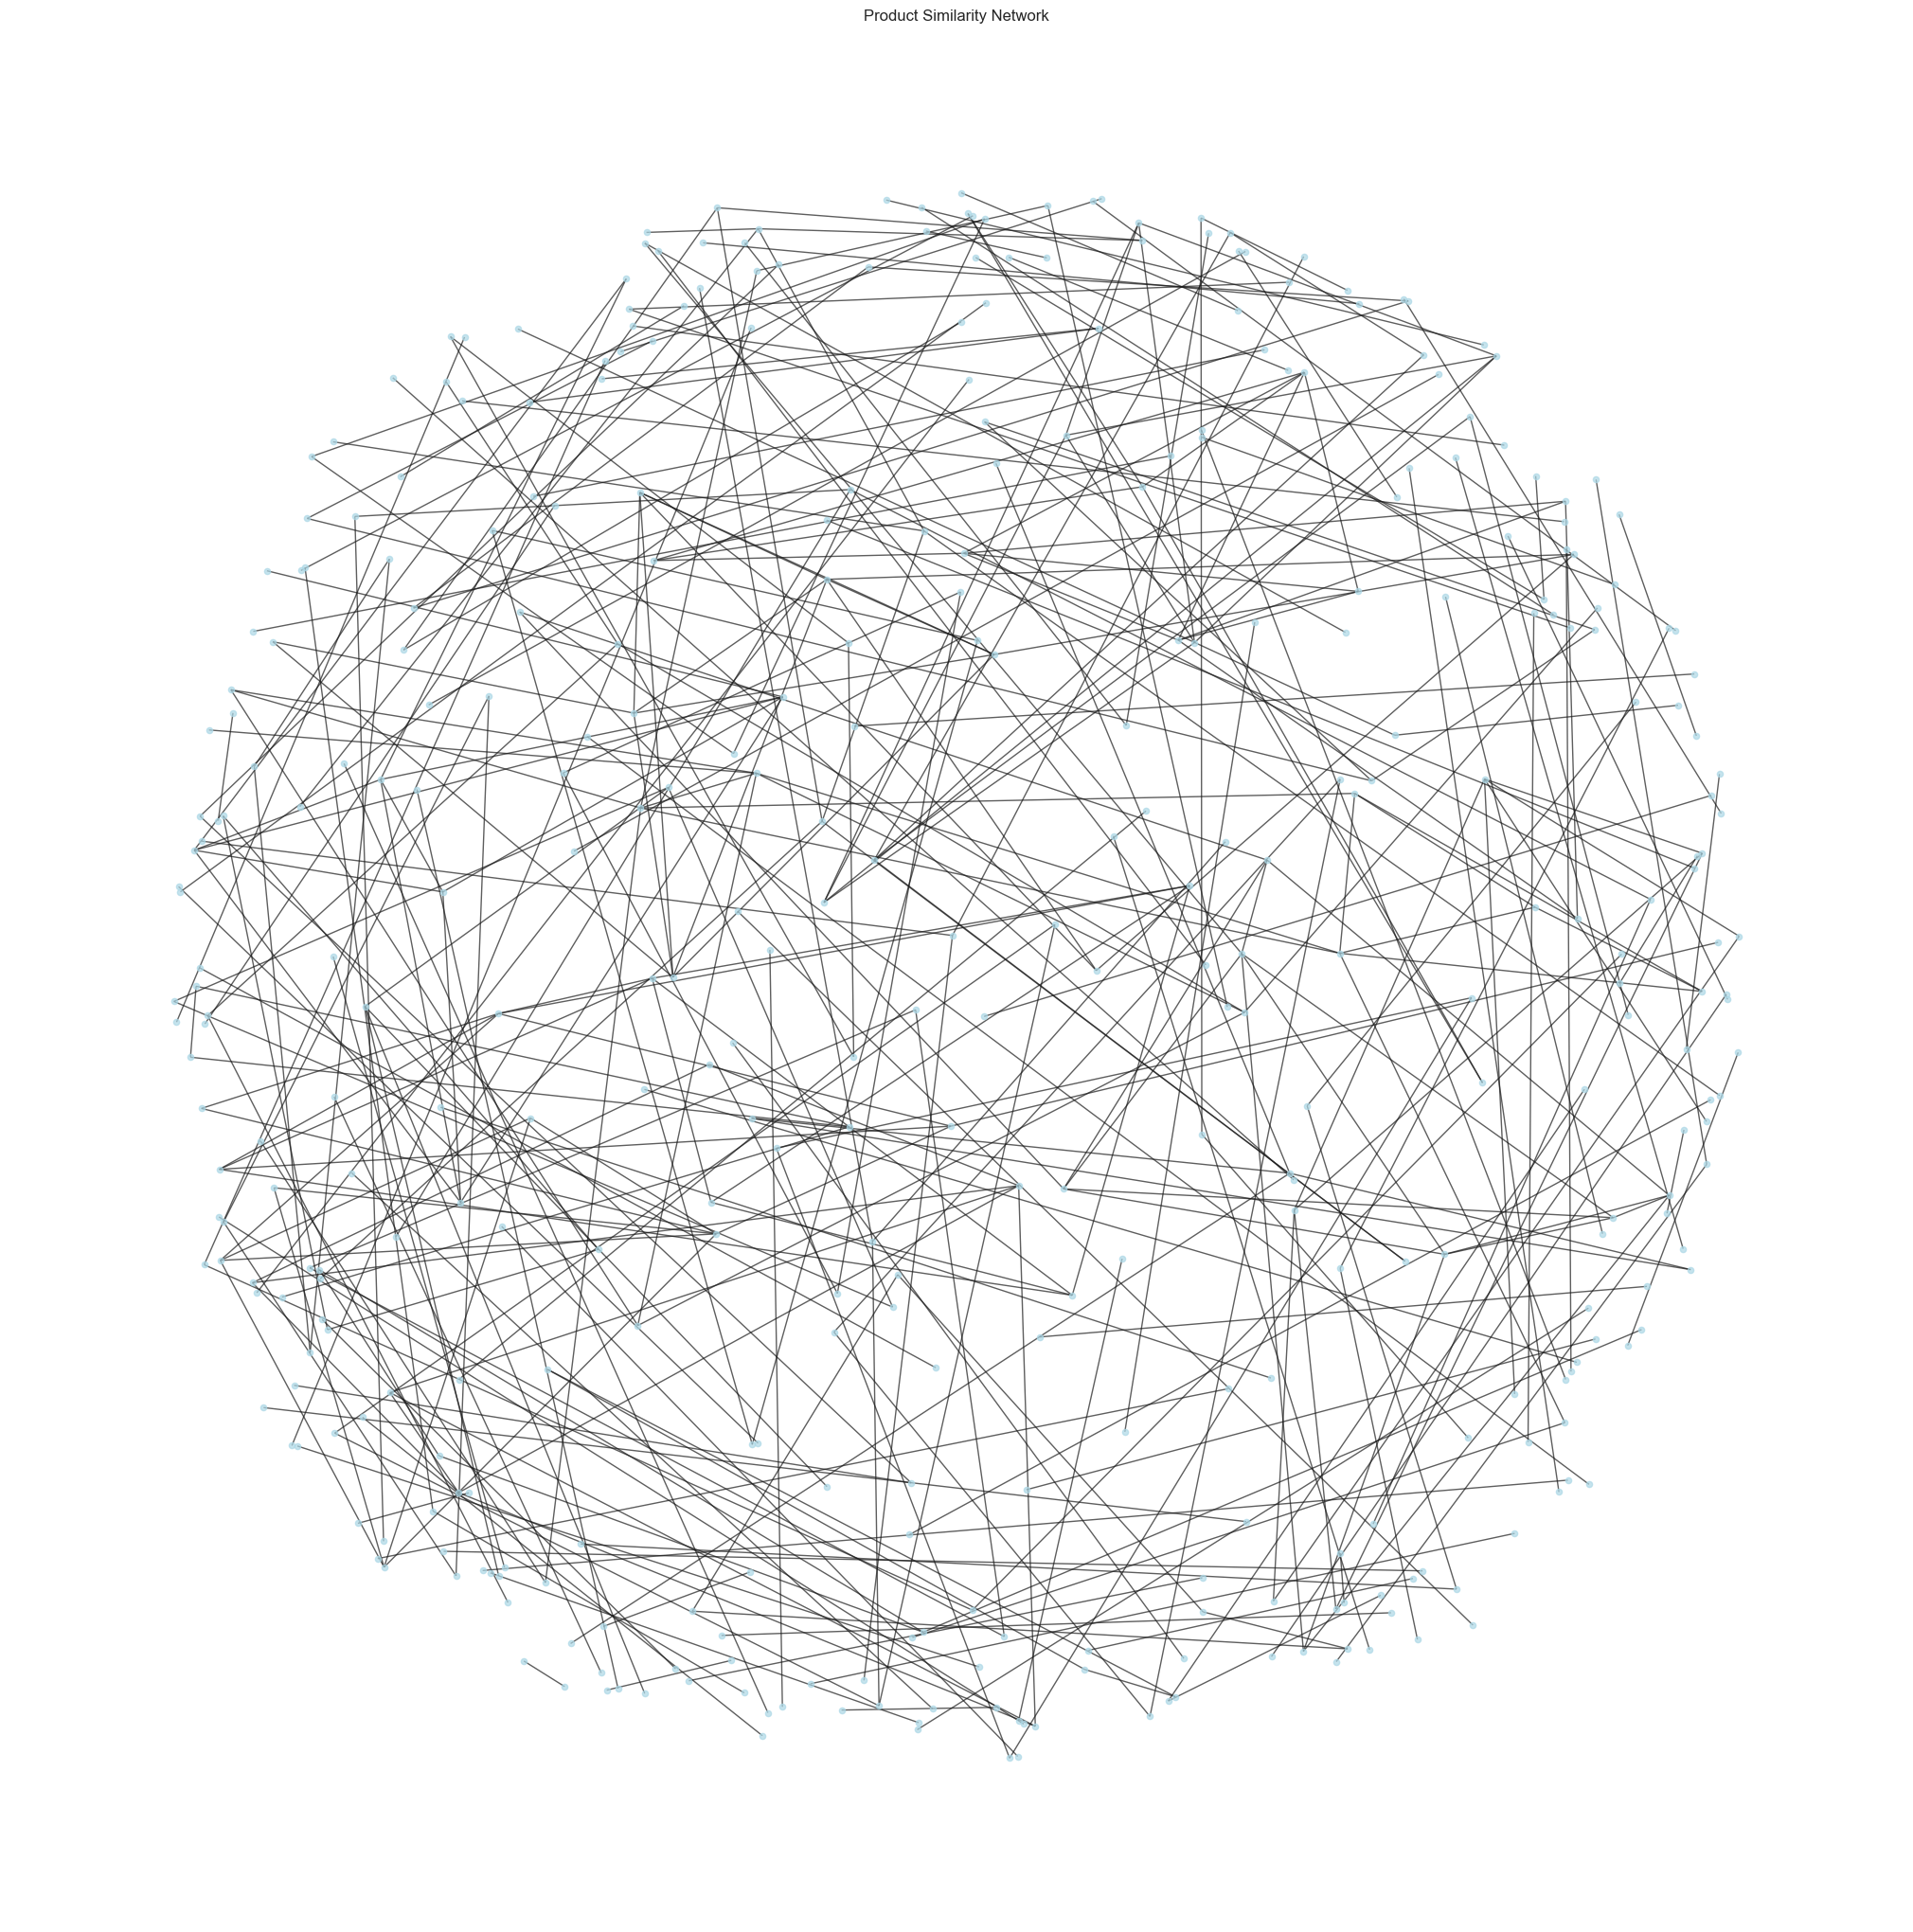

In [17]:
# Visualize the graph
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G, k=0.5, iterations=50)
nx.draw(G, pos, node_size=20, node_color="lightblue", with_labels=False, alpha=0.7)
plt.title("Product Similarity Network")
plt.axis("off")
plt.tight_layout()
plt.show()

In [20]:
# Find clusters of similar products
clusters = list(nx.connected_components(G))

# Print information about the clusters
print(f"Number of clusters: {len(clusters)}")
print(f"Sizes of the 5 largest clusters: {sorted([len(c) for c in clusters], reverse=True)[:5]}")

Number of clusters: 128
Sizes of the 5 largest clusters: [22, 18, 14, 10, 10]


In [21]:
# Function to get cluster details
def get_cluster_details(cluster):
    cluster_products = products.iloc[list(cluster)]
    return cluster_products[["name", "manufacturer", "processor", "memory", "description"]].to_dict("records")

In [22]:
# Print details of the largest cluster
largest_cluster = max(clusters, key=len)
print("\nDetails of the largest cluster:")
for product in get_cluster_details(largest_cluster)[:20]:  # Print first 5 products
    print(
        f"Name: {product['name']}, Manufacturer: {product['manufacturer']}, Processor: {product['processor']}, Memory: {product['memory']},, Description: {product['description']}"
    )


Details of the largest cluster:
Name: aimb-qg/ae, Manufacturer: Advantech, Processor: Intel Core i3/i5/i7, Pentium, Memory: Dual Channel DDR3, Max Capacity 32 GB, 4 x 240-pin DIMM,, Description: Industrial motherboard supporting Intel Core i3/i5/i7 and Pentium processors, with dual display, dual GbE LAN, SATA RAID, and various expansion slots.
Name: aimb-q670, Manufacturer: Advantech, Processor: 3rd Generation Intel Core i3/i5/i7, Pentium, Celeron, Memory: Dual Channel DDR3, up to 32 GB,, Description: The AIMB-Q670 is an industrial motherboard designed for high-performance computing with support for 3rd generation Intel Core processors. It features dual display support, dual GbE LAN, SATA RAID, and AMT, making it suitable for a wide range of industrial applications.
Name: aimb-gu-ae, Manufacturer: Advantech, Processor: Intel Core i7/i5/i3, Intel Celeron U, Memory: Dual Channel DDR3L 1600 MHz, Max Capacity 16 GB (8 GB per SODIMM),, Description: The AIMB-GU-AE is an industrial motherboa

<Figure size 1500x1500 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Heatmap of Product Similarities (Subset)')

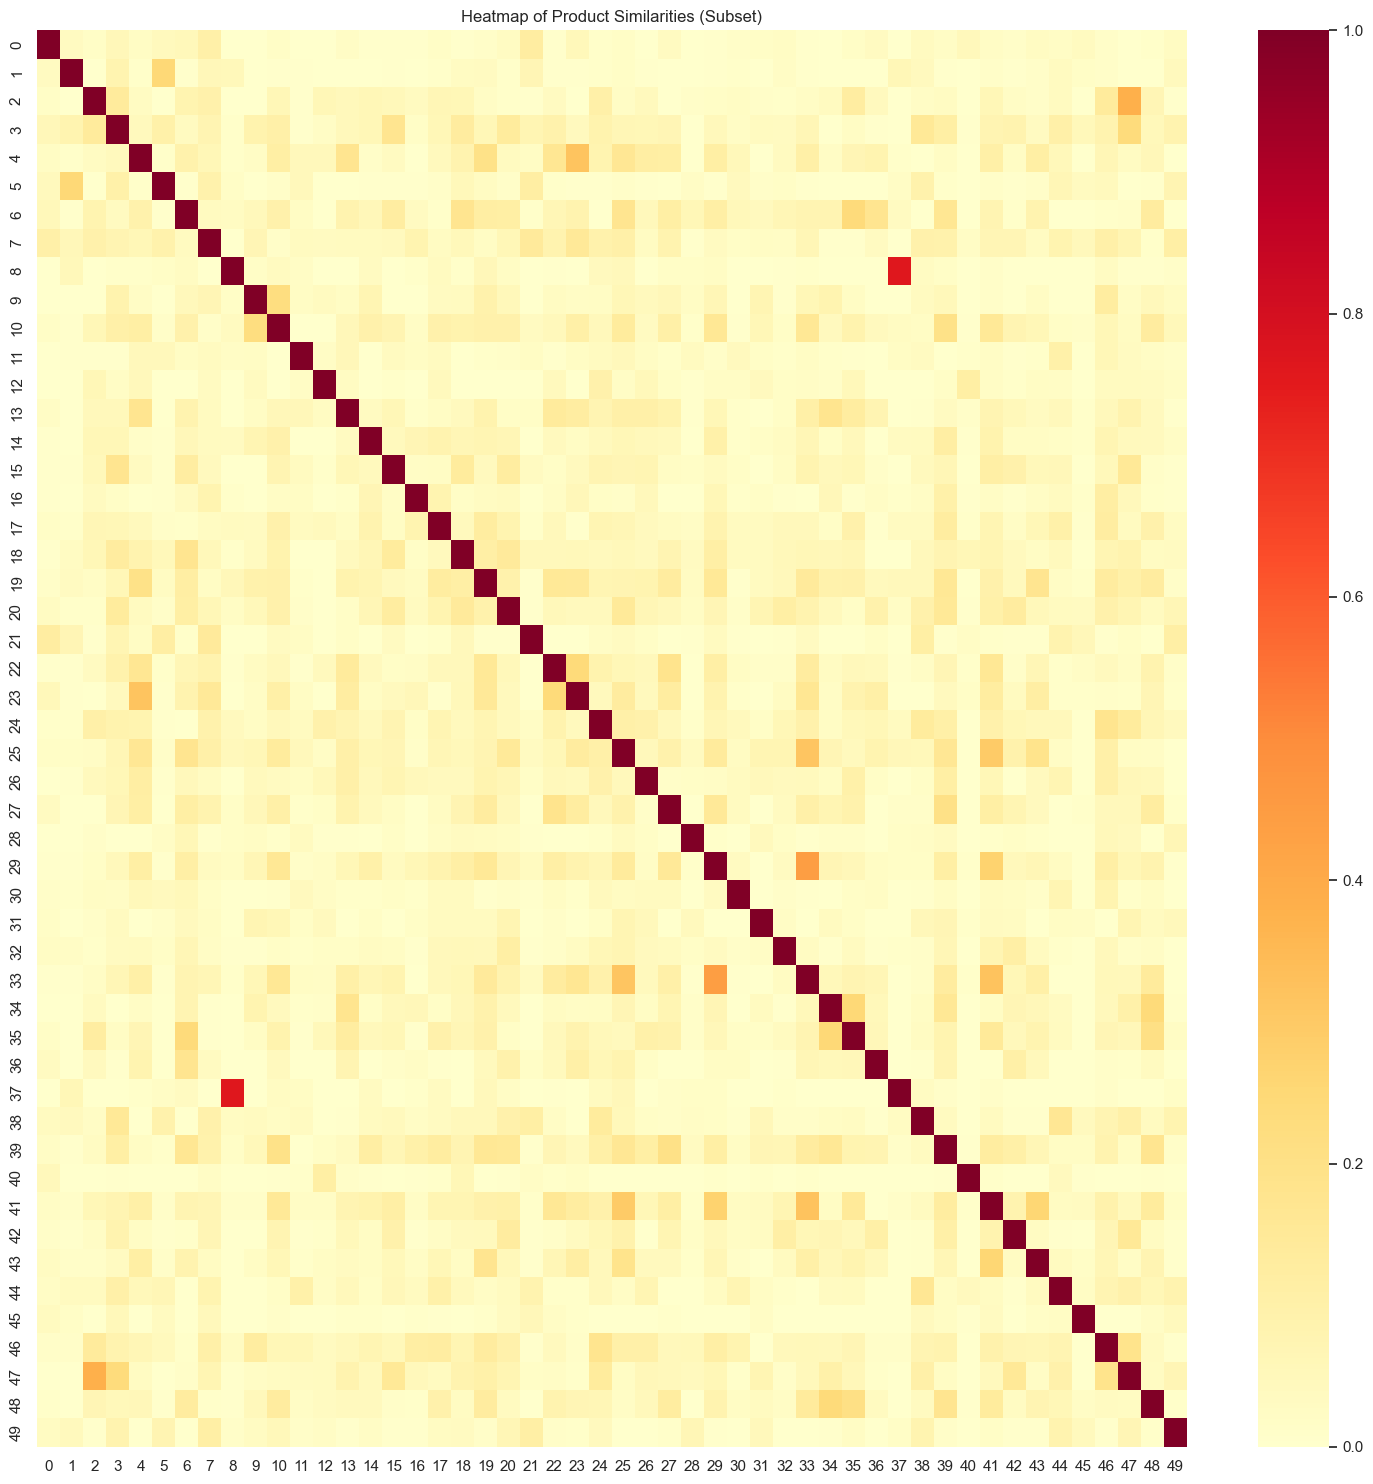

In [33]:
# Heatmap of similarities for a subset of products
subset_size = 50
subset_indices = np.random.choice(len(products), subset_size, replace=False)
subset_sim = cosine_sim[subset_indices][:, subset_indices]

plt.figure(figsize=(15, 15))
sns.heatmap(subset_sim, cmap="YlOrRd")
plt.title("Heatmap of Product Similarities (Subset)")
plt.tight_layout()
plt.show()